### <font color='indigo'>1) Import the Required Packages and Load the Dataset

In [1]:
#!pip install xgboost
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
pd.options.display.max_rows = 8
df = pd.read_csv("CR1_Data_Processed.csv", header=0, skiprows=0)
df

,person_age,person_income,person_home_ownership,loan_intent,loan_grade,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_int_rate,person_emp_length
0,21,9600,OWN,EDUCATION,B,1000,0,0.10,N,2,11.14,5.0
1,25,9600,MORTGAGE,MEDICAL,C,5500,1,0.57,N,3,12.87,1.0
2,23,65500,RENT,MEDICAL,C,35000,1,0.53,N,2,15.23,4.0
3,24,54400,RENT,MEDICAL,C,35000,1,0.55,Y,4,14.27,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32570,54,120000,MORTGAGE,PERSONAL,A,17625,0,0.15,N,19,7.49,4.0
32571,65,76000,RENT,HOMEIMPROVEMENT,B,35000,1,0.46,N,28,10.99,3.0
32572,56,150000,MORTGAGE,PERSONAL,B,15000,0,0.10,N,26,11.48,5.0
32573,66,42000,RENT,MEDICAL,B,6475,0,0.15,N,30,9.99,2.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32574 entries, 0 to 32573
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   loan_intent                 32574 non-null  object 
 4   loan_grade                  32574 non-null  object 
 5   loan_amnt                   32574 non-null  int64  
 6   loan_status                 32574 non-null  int64  
 7   loan_percent_income         32574 non-null  float64
 8   cb_person_default_on_file   32574 non-null  object 
 9   cb_person_cred_hist_length  32574 non-null  int64  
 10  loan_int_rate               32574 non-null  float64
 11  person_emp_length           32574 non-null  float64
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


### <font color='indigo'>2) Data Preparation for the Model

* The categorical variables need to be encoded so that they can be used in models.

In [4]:
df = pd.get_dummies(df) #for one-hot encoding
df.head()

,person_age,person_income,loan_amnt,loan_status,loan_percent_income,cb_person_cred_hist_length,loan_int_rate,person_emp_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,21,9600,1000,0,0.10,2,11.14,5.0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,25,9600,5500,1,0.57,3,12.87,1.0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,23,65500,35000,1,0.53,2,15.23,4.0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,24,54400,35000,1,0.55,4,14.27,8.0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,21,9900,2500,1,0.25,2,7.14,2.0,0,0,...,1,1,0,0,0,0,0,0,1,0


#### Predictors-Target Split

In [5]:
X = df.drop(["loan_status"], axis=1) #predictors
Y = df[["loan_status"]] #target

#### Train-Valid-Test Split

* Splitting the whole dataset into three sets: train, validation, and test with ratios of 80%, 10%, and 10% respectively.

In [6]:
train_size=0.8
X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.8, random_state=777)

test_size = 0.5
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=777)

print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(26059, 26)
(26059, 1)
(3257, 26)
(3257, 1)
(3258, 26)
(3258, 1)


(None, None)

### <font color='indigo'>3) Model Building

In [7]:
model_xgb = xgb.XGBClassifier(learning_rate=0.1,
                             max_depth=5,
                             n_estimators=5000,
                             subsample=0.5,
                             colsample_bytree=0.5,
                             eval_metric="auc",
                             verbosity=1)

eval_set = [(X_valid, Y_valid)]

# Fitting the model
model_xgb.fit(X_train,
              np.ravel(Y_train),
              early_stopping_rounds=10,
              eval_set=eval_set,
              verbose=True)

[0]	validation_0-auc:0.84927
[1]	validation_0-auc:0.88971


C:\Users\Dell\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.89080
[3]	validation_0-auc:0.89851
[4]	validation_0-auc:0.90402
[5]	validation_0-auc:0.90693
[6]	validation_0-auc:0.90687
[7]	validation_0-auc:0.90725
[8]	validation_0-auc:0.90730
[9]	validation_0-auc:0.90886
[10]	validation_0-auc:0.90867
[11]	validation_0-auc:0.90933
[12]	validation_0-auc:0.91069
[13]	validation_0-auc:0.91153
[14]	validation_0-auc:0.91371
[15]	validation_0-auc:0.91501
[16]	validation_0-auc:0.91482
[17]	validation_0-auc:0.91624
[18]	validation_0-auc:0.91588
[19]	validation_0-auc:0.91700
[20]	validation_0-auc:0.91703
[21]	validation_0-auc:0.91712
[22]	validation_0-auc:0.91811
[23]	validation_0-auc:0.91839
[24]	validation_0-auc:0.91964
[25]	validation_0-auc:0.92066
[26]	validation_0-auc:0.92085
[27]	validation_0-auc:0.92198
[28]	validation_0-auc:0.92187
[29]	validation_0-auc:0.92241
[30]	validation_0-auc:0.92283
[31]	validation_0-auc:0.92315
[32]	validation_0-auc:0.92375
[33]	validation_0-auc:0.92437
[34]	validation_0-auc:0.92530
[35]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

### <font color='indigo'>4) Model Performance Indicators

In [8]:
Y_train_pred = model_xgb.predict_proba(X_train)[:,1]
Y_valid_pred = model_xgb.predict_proba(X_valid)[:,1]
Y_test_pred = model_xgb.predict_proba(X_test)[:,1]

In [9]:
print(f"AUC train: {roc_auc_score(Y_train, Y_train_pred):1f}")
print(f"AUC valid: {roc_auc_score(Y_valid, Y_valid_pred):1f}")

AUC train: 0.963048
AUC valid: 0.943822


Text(0.5, 23.52222222222222, 'Predicted label')

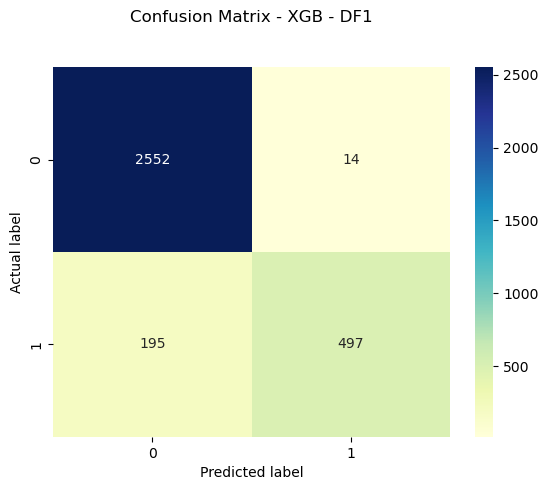

In [25]:
Y_pred_cat_1 = model_xgb.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred_cat_1)
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion Matrix - XGB - DF1', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

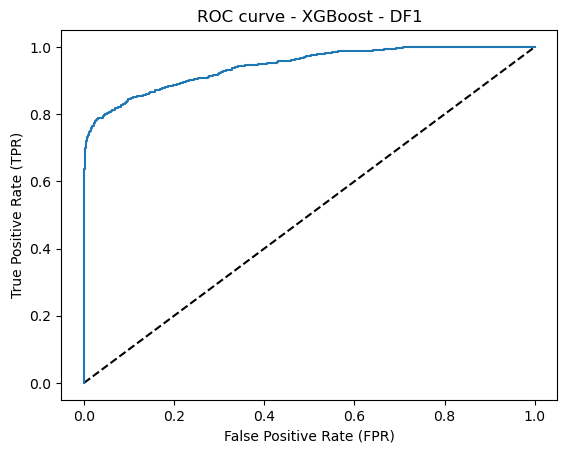

In [11]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve - XGBoost - DF1')
plt.show()

In [12]:
print(f"AUC test: {roc_auc_score(Y_test, Y_test_pred):1f}")

AUC test: 0.943325


### <font color='indigo'>5) Hyperparameter Tuning

In [14]:
learning_rate_vals = [0.05, 0.1, 0.15, 0.25, 0.3]
max_dept_vals = [3, 4, 5, 6, 8, 10, 12, 15]
n_estimators_vals = [3000, 5000, 7000]

parameters = {"learning_rate": learning_rate_vals,
             "max_depth": max_dept_vals,
             "n_estimators": n_estimators_vals}

random_search = RandomizedSearchCV(model_xgb, param_distributions=parameters, n_iter=5, scoring="roc_auc",
                                  n_jobs=-1, cv=5, verbose=3)

random_search

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.5,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=0,
                                           gpu_id=-1, grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0....
                                           max_delta_step=0, max_depth=5,
                                           max_leaves=0, min_child_weight=1,
                                           missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=5000, n_jobs=0,
                                           num_parallel_tree=1,
                                           predictor='auto', random_state=0, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.25,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'n_estimators': [3000, 5000, 7000]},
                   scoring='roc_auc', verbose=3)

### <font color='indigo'>6) Final Model

In [15]:
model_xgb_final = xgb.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=5000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0)

eval_set = [(X_valid, Y_valid)]

model_xgb_final.fit(X_train,
              np.ravel(Y_train),
              early_stopping_rounds=20,
              eval_set=eval_set,
              verbose=True)

[0]	validation_0-auc:0.84890
[1]	validation_0-auc:0.88508
[2]	validation_0-auc:0.88111
[3]	validation_0-auc:0.89981
[4]	validation_0-auc:0.90272
[5]	validation_0-auc:0.89938
[6]	validation_0-auc:0.90065
[7]	validation_0-auc:0.90253


C:\Users\Dell\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-auc:0.90405
[9]	validation_0-auc:0.90292
[10]	validation_0-auc:0.90838
[11]	validation_0-auc:0.90840
[12]	validation_0-auc:0.90836
[13]	validation_0-auc:0.91036
[14]	validation_0-auc:0.91105
[15]	validation_0-auc:0.91192
[16]	validation_0-auc:0.91207
[17]	validation_0-auc:0.91317
[18]	validation_0-auc:0.91334
[19]	validation_0-auc:0.91351
[20]	validation_0-auc:0.91383
[21]	validation_0-auc:0.91467
[22]	validation_0-auc:0.91513
[23]	validation_0-auc:0.91546
[24]	validation_0-auc:0.91575
[25]	validation_0-auc:0.91661
[26]	validation_0-auc:0.91725
[27]	validation_0-auc:0.91821
[28]	validation_0-auc:0.91808
[29]	validation_0-auc:0.91893
[30]	validation_0-auc:0.91986
[31]	validation_0-auc:0.92121
[32]	validation_0-auc:0.92195
[33]	validation_0-auc:0.92275
[34]	validation_0-auc:0.92380
[35]	validation_0-auc:0.92413
[36]	validation_0-auc:0.92413
[37]	validation_0-auc:0.92437
[38]	validation_0-auc:0.92484
[39]	validation_0-auc:0.92557
[40]	validation_0-auc:0.92630
[41]	validat

[276]	validation_0-auc:0.95067
[277]	validation_0-auc:0.95066
[278]	validation_0-auc:0.95064
[279]	validation_0-auc:0.95054
[280]	validation_0-auc:0.95056
[281]	validation_0-auc:0.95059
[282]	validation_0-auc:0.95056
[283]	validation_0-auc:0.95057
[284]	validation_0-auc:0.95063
[285]	validation_0-auc:0.95061
[286]	validation_0-auc:0.95060
[287]	validation_0-auc:0.95061
[288]	validation_0-auc:0.95057
[289]	validation_0-auc:0.95062
[290]	validation_0-auc:0.95058
[291]	validation_0-auc:0.95056
[292]	validation_0-auc:0.95054
[293]	validation_0-auc:0.95053
[294]	validation_0-auc:0.95063


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [17]:
Y_train_pred_2 = model_xgb_final.predict_proba(X_train)[:,1]
Y_valid_pred_2 = model_xgb_final.predict_proba(X_valid)[:,1]
Y_test_pred_2 = model_xgb_final.predict_proba(X_test)[:,1]

In [18]:
print(f"AUC train: {roc_auc_score(Y_train, Y_train_pred_2):1f}")
print(f"AUC valid: {roc_auc_score(Y_valid, Y_valid_pred_2):1f}")

AUC train: 0.976421
AUC valid: 0.950703


In [19]:
model_pred_prob = model_xgb_final.predict_proba(X_test)
model_pred_label = model_xgb_final.predict(X_test)

target_names = ['Non-Default', 'Default']
print(classification_report(Y_test, model_pred_label, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      2566
     Default       0.97      0.73      0.83       692

    accuracy                           0.94      3258
   macro avg       0.95      0.86      0.90      3258
weighted avg       0.94      0.94      0.93      3258



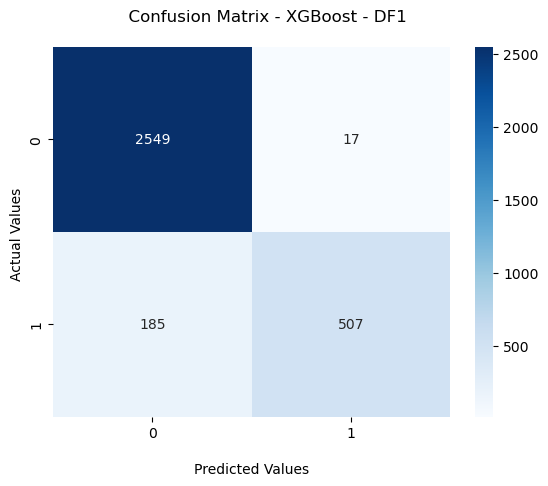

In [30]:
cm_final_model = confusion_matrix(Y_test, model_pred_label)
ax = sns.heatmap(cm_final_model, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt="d")
ax.set_title('      Confusion Matrix - XGBoost - DF1\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

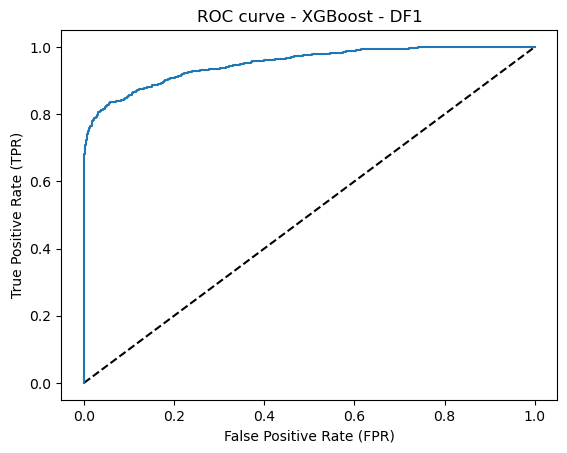

In [21]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_pred_2)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve - XGBoost - DF1')
plt.show()

In [22]:
print(f"AUC test: {roc_auc_score(Y_test, Y_test_pred_2):1f}")

AUC test: 0.950650


#### Feature Selection in Xgboost

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

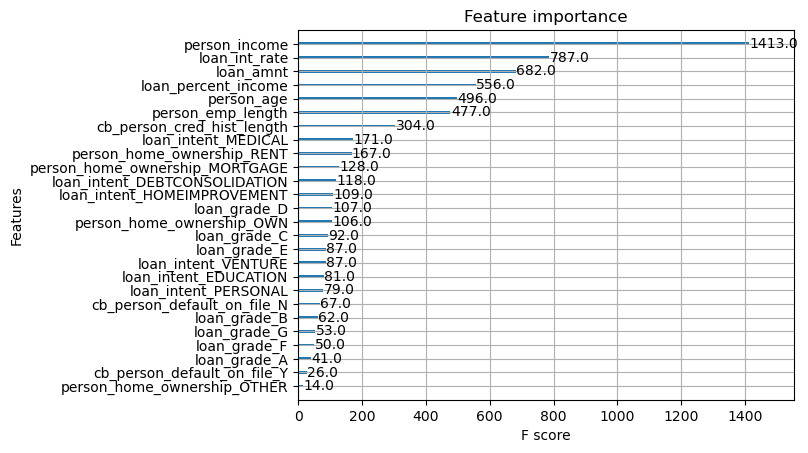

In [23]:
xgb.plot_importance(model_xgb_final, importance_type="weight")